In [2]:
%load_ext autoreload
%autoreload 1
%aimport environment

from environment import CarEnv

import numpy as np

import matplotlib.pyplot as plt

In [3]:
env = CarEnv(0, False)
print(env.observation_space.shape) # size of the image
print(env.action_space) 
action_dim = env.action_space.n

(40, 40, 3)
Discrete(8)


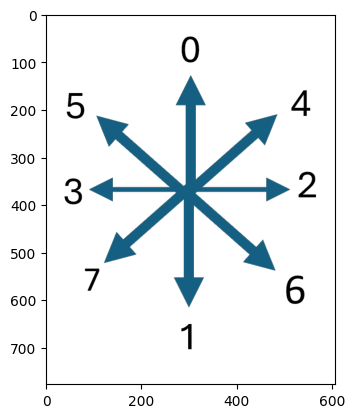

In [4]:
img = plt.imread("action space.png")
plt.imshow(img)

### test

In [4]:
# Create an instance of the custom environment
env = CarEnv(10)

# Example of using the environment
obs = env.reset()
score = 0
while True:
    action = env.action_space.sample()
    obs, reward, done, _ = env.step(action)
    score += reward
    if done:
        break

print('Score:', score)

Score: 3.7954194487551103


In [5]:
env = CarEnv(10,False)
obs = env.reset()


0.014579528055708398


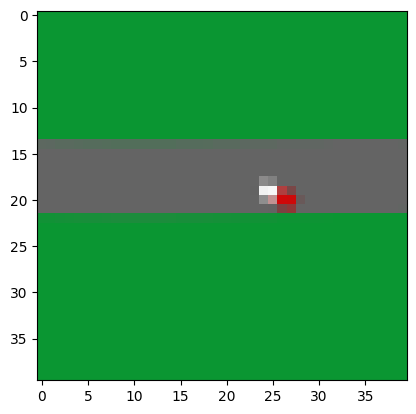

In [6]:
# Size of the image is reduced to make training faster
action = env.action_space.sample()
obs, reward, done, _ = env.step(0)

print(reward)
fig = plt.figure
plt.imshow(obs)

### DL models

In [7]:
import torch
import pandas as pd
import seaborn as sns

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [8]:
from deep_Q_newtork import EpsilonGreedy, MinimumExponentialLR, DQNAgent
from policy import QNetwork, OtherQNetwork
%aimport deep_Q_newtork


c:\Users\matth\Documents\X\INFautonomous\Projet\env\lib\site-packages\torchrl\data\replay_buffers\samplers.py:37: UserWarning: Failed to import torchrl C++ binaries. Some modules (eg, prioritized replay buffers) may not work with your installation. If you installed TorchRL from PyPI, please report the bug on TorchRL github. If you installed TorchRL locally and/or in development mode, check that you have all the required compiling packages.
  warnings.warn(EXTENSION_WARNING)


In [9]:
env = CarEnv(10, display=True)
obs = env.reset()
obstensor = CarEnv.obs2tensor(obs, device)

model = QNetwork(action_dim).to(device)

model(obstensor)

tensor([[-4.4175, -4.9756, -4.4853, -1.8915,  3.6362,  1.0354, -5.9361,  0.9314]],
       device='cuda:0', grad_fn=<AddmmBackward0>)

In [8]:
env = CarEnv(30, False)

loss_fn = torch.nn.MSELoss()

NUMBER_OF_TRAININGS = 1

for train_index in range(NUMBER_OF_TRAININGS):

    # Instantiate required objects

    q_network = QNetwork(action_dim).to(device)
    target_q_network = QNetwork(action_dim).to(device)
    optimizer = torch.optim.AdamW(
        q_network.parameters(), lr=0.004, amsgrad=True)
    epsilon_greedy = EpsilonGreedy(
        epsilon_start=0.9, epsilon_min=0.01, epsilon_decay=0.97, env=env, q_network=q_network)
    # lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.999)
    lr_scheduler = MinimumExponentialLR(
        optimizer, lr_decay=0.99, min_lr=0.0001)

    # Train the q-network
    dqn_agent = DQNAgent(env=env,
                         q_network=q_network,
                         target_q_network=target_q_network,
                         target_q_network_sync_period=50,
                         device=device,
                         gamma=0.85,
                         )

    dqn_agent.train(num_episodes=300,
                    batch_size=128,
                    loss_fn=loss_fn,
                    epsilon_greedy=epsilon_greedy,
                    optimizer=optimizer,
                    lr_scheduler=lr_scheduler,
                    frame_skipping=10,
                    )

# Save the action-value estimation function

torch.save(q_network, "models/dqn2_q_network.pth")

  0%|          | 0/299 [00:00<?, ?it/s]

c:\Users\matth\Documents\X\INFautonomous\Projet\environment.py:227: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(obs, dtype=torch.float32).permute(0, 3, 1, 2).to(device)
c:\Users\matth\Documents\X\INFautonomous\Projet\deep_Q_newtork.py:114: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch_actions_tensor = torch.tensor(
c:\Users\matth\Documents\X\INFautonomous\Projet\deep_Q_newtork.py:116: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch_rewards_tensor = torch.tensor(
c:\Users\matth\Documents\X\INFautonomous\Proj

Episode 1 - Reward: 2.7811854298088745
Episode 2 - Reward: -7.845757401595293
Episode 3 - Reward: 8.66507560976048
Episode 4 - Reward: 1.640937700409339
Episode 5 - Reward: 21.108007055471827
Episode 6 - Reward: 10.65710477433843
Episode 7 - Reward: 4.8151494659974325
Episode 8 - Reward: 10.531171869757838
Episode 9 - Reward: 5.934242288524562
Episode 10 - Reward: 9.866199886371454
Episode 11 - Reward: 2.5452900151219175
Episode 12 - Reward: 5.36450144588562
Episode 13 - Reward: 18.20684447789659
Episode 14 - Reward: 19.026428481822744
Episode 15 - Reward: 2.0278501945689396
Episode 16 - Reward: 7.490597946794236
Episode 17 - Reward: 8.733963628057648
Episode 18 - Reward: 24.42971242746238
Episode 19 - Reward: 2.7384739201945485
Episode 20 - Reward: 4.39894742567354
Episode 21 - Reward: 7.936347711094517
Episode 22 - Reward: 6.434610822829093
Episode 23 - Reward: 12.335566729122249
Episode 24 - Reward: 2.614949803756231
Episode 25 - Reward: 3.757948619646711
Episode 26 - Reward: 2.1494

In [10]:
env.close()

In [9]:
dqn2_trains_result_df = pd.DataFrame(np.array(dqn_agent.result_list).T, columns=["num_episodes", "mean_final_episode_reward", "training_index"])
dqn2_trains_result_df["agent"] = "DQN 2015"

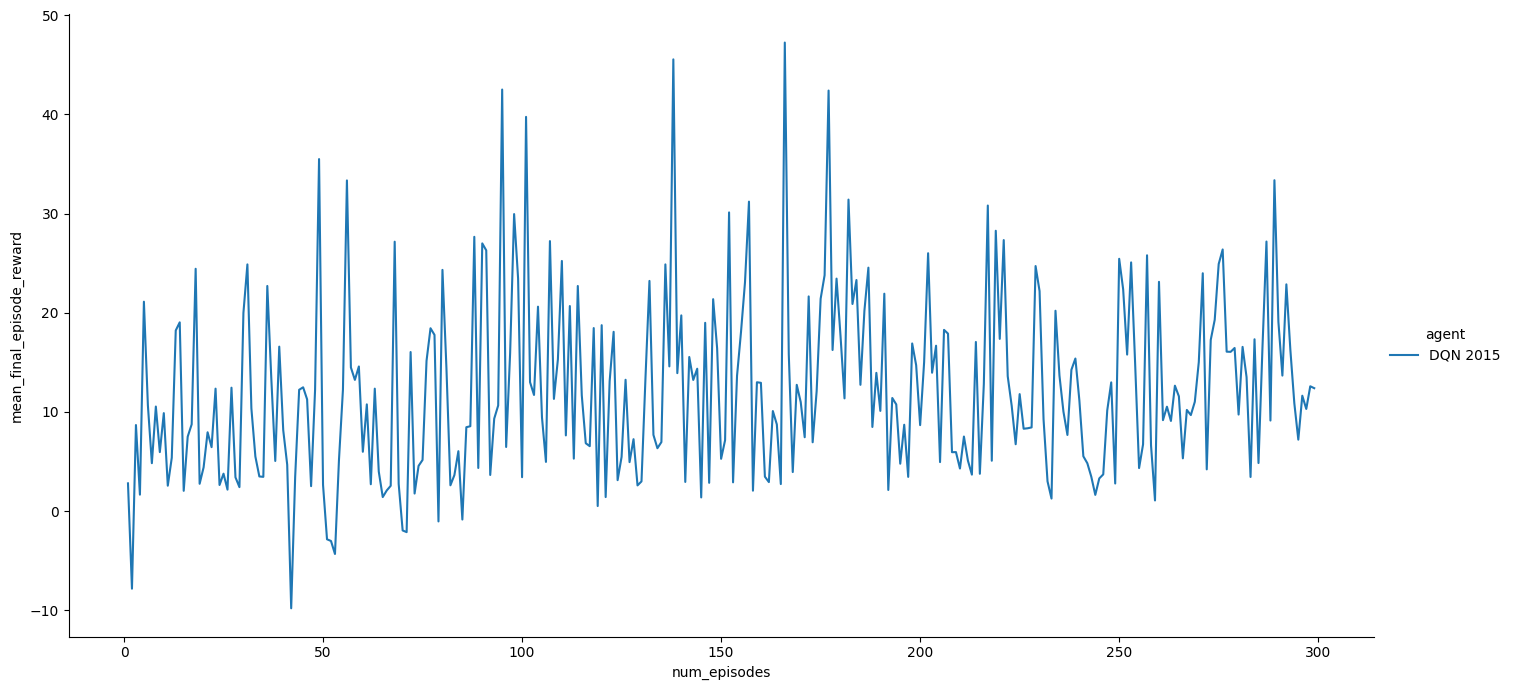

In [10]:
g = sns.relplot(x="num_episodes",
                y="mean_final_episode_reward",
                kind="line",
                hue="agent",
                estimator=None,
                units="training_index",
                data=dqn2_trains_result_df,
                height=7,
                aspect=2)

In [10]:
q_network = torch.load("models/dqn2_q_network.pth", map_location=device)

In [15]:
env = CarEnv(30, False)

target_q_network = QNetwork(action_dim).to(device)
optimizer = torch.optim.AdamW(
    q_network.parameters(), lr=0.004, amsgrad=True)
epsilon_greedy = EpsilonGreedy(
    epsilon_start=0.9, epsilon_min=0.01, epsilon_decay=0.97, env=env, q_network=q_network)
# lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.999)
lr_scheduler = MinimumExponentialLR(
    optimizer, lr_decay=0.99, min_lr=0.0001)

# Train the q-network
dqn_agent = DQNAgent(env=env,
                        q_network=q_network,
                        target_q_network=target_q_network,
                        target_q_network_sync_period=50,
                        device=device,
                        gamma=0.85,
                        )

dqn_agent.train(num_episodes=300,
                batch_size=128,
                loss_fn=loss_fn,
                epsilon_greedy=epsilon_greedy,
                optimizer=optimizer,
                lr_scheduler=lr_scheduler,
                frame_skipping=1,
                )

# Save the action-value estimation function

torch.save(q_network, "models/dqn2_q_network.pth")

  0%|          | 0/299 [00:00<?, ?it/s]

c:\Users\matth\Documents\X\INFautonomous\Projet\environment.py:227: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(obs, dtype=torch.float32).permute(0, 3, 1, 2).to(device)
c:\Users\matth\Documents\X\INFautonomous\Projet\deep_Q_newtork.py:114: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch_actions_tensor = torch.tensor(
c:\Users\matth\Documents\X\INFautonomous\Projet\deep_Q_newtork.py:116: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch_rewards_tensor = torch.tensor(
c:\Users\matth\Documents\X\INFautonomous\Proj

Episode 1 - Reward: 4.6094890953318775
Episode 2 - Reward: 37.19472553274642
Episode 3 - Reward: 7.347336846931679
Episode 4 - Reward: 7.983074615259958
Episode 5 - Reward: 28.53250935039023
Episode 6 - Reward: 3.0171840503967586
Episode 7 - Reward: 4.757358753348994
Episode 8 - Reward: 4.763651546827139
Episode 9 - Reward: 3.8500050549736473
Episode 10 - Reward: 3.4539874664828143
Episode 11 - Reward: 7.265878179215446
Episode 12 - Reward: 17.06046584023958
Episode 13 - Reward: 44.03526392306323
Episode 14 - Reward: 6.679541817589381
Episode 15 - Reward: 6.659539245898463
Episode 16 - Reward: 18.81039660336173
Episode 17 - Reward: 4.227346808761579
Episode 18 - Reward: 4.105197443361304
Episode 19 - Reward: 13.064695166374984
Episode 20 - Reward: 3.660040815258247
Episode 21 - Reward: 43.103024402766465
Episode 22 - Reward: 9.487670857690157
Episode 23 - Reward: 16.472687218672206
Episode 24 - Reward: 2.6155933075421354
Episode 25 - Reward: 9.344697957356896
Episode 26 - Reward: 36.51

In [23]:
dqn2_trains_result_df = pd.DataFrame(np.array(dqn_agent.result_list).T, columns=["num_episodes", "mean_final_episode_reward", "training_index"])
dqn2_trains_result_df["agent"] = "DQN 2015"

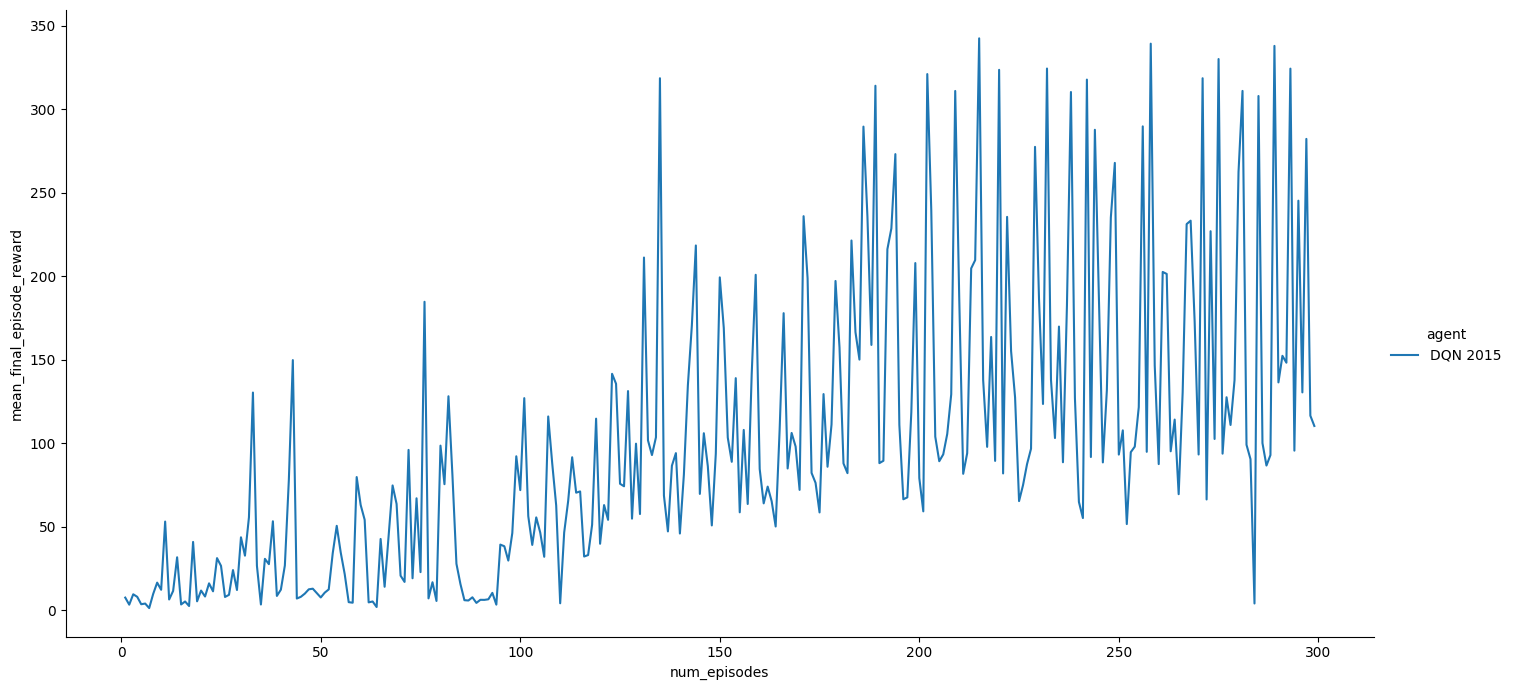

In [24]:
g = sns.relplot(x="num_episodes",
                y="mean_final_episode_reward",
                kind="line",
                hue="agent",
                estimator=None,
                units="training_index",
                data=dqn2_trains_result_df,
                height=7,
                aspect=2)

### Run the game with a trained model

In [11]:
import pygame as pg

#q_network = torch.load("models/verygood2.pth", map_location=device)

# Create an instance of the custom environment
env = CarEnv(300,display=True, evaluation=False, draw_central_line=True)

# Example of using the environment
obs = env.reset()
score = 0

while True:
    obstensor = CarEnv.obs2tensor(obs, device)
    action = q_network(obstensor).argmax(dim=1)
    obs, reward, done, _ = env.step(action)
    score += reward
    if done:
        break
print(score)

129.0817568136935
